In [1]:
!pip install av transformers huggingface_hub music21 midi2audio einops timm -q
!pip install opencv-python -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.8 MB/s eta 0:00:00


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import av
import torch
import numpy as np
from transformers import AutoProcessor, AutoModel, VideoMAEModel, VideoMAEImageProcessor, VideoMAEConfig
from huggingface_hub import hf_hub_download
import cv2
from music21 import note, scale, stream
from music21 import stream, chord, note, roman, scale, volume, environment
import random
from music21 import midi

# np.random.seed(0)

In [29]:
def read_video_pyav(container, indices):
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

In [27]:
file_path = "/content/drive/MyDrive/Video2Music/ice.mp4"
container = av.open(file_path)

# sample 16 frames
indices = sample_frame_indices(clip_len=16, frame_sample_rate=8, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("microsoft/xclip-base-patch32")
model = AutoModel.from_pretrained("microsoft/xclip-base-patch32-16-frames")
model.to(device)

classes = [
    "dominant colour of this video is Red, Hex: #ff0000",  # C
    "dominant colour of this video is Orange-pink, Hex: #ff7f00",  # G
    "dominant colour of this video is Yellow, Hex: #ffff00",  # D
    "dominant colour of this video is Green, Hex: #00ff00",  # A
    "dominant colour of this video is Whitish-blue, Hex: #c3ffff",  # E
    "dominant colour of this video is Blue, Hex: #8cc8ff",  # B
    "dominant colour of this video is Blue, Bright, Hex: #808bff",  # G♭
    "dominant colour of this video is Violet, Hex: #7f00ff",  # D♭
    "dominant colour of this video is Purplish-violet, Hex: #bb75ff",  # A♭
    "dominant colour of this video is Steel colour with metallic sheen, Hex: #b7468b",  # E♭
    "dominant colour of this video is Rosé, Hex: #a9677c",  # B♭
    "dominant colour of this video is Deep-red, Hex: #ab0034"  # F
]

chord_map = {
    "dominant colour of this video is Red, Hex: #ff0000": "C",
    "dominant colour of this video is Orange-pink, Hex: #ff7f00": "G",
    "dominant colour of this video is Yellow, Hex: #ffff00": "D",
    "dominant colour of this video is Green, Hex: #00ff00": "A",
    "dominant colour of this video is Whitish-blue, Hex: #c3ffff": "E",
    "dominant colour of this video is Blue, Hex: #8cc8ff": "B",
    "dominant colour of this video is Blue, Bright, Hex: #808bff": "G-",
    "dominant colour of this video is Violet, Hex: #7f00ff": "D-",
    "dominant colour of this video is Purplish-violet, Hex: #bb75ff": "A-",
    "dominant colour of this video is Steel colour with metallic sheen, Hex: #b7468b": "E-",
    "dominant colour of this video is Rosé, Hex: #a9677c": "B-",
    "dominant colour of this video is Deep-red, Hex: #ab0034": "F"
}

colour_note_map = {
"C": (255, 0, 0), # Red
"G": (255, 127, 0), # Orange-pink
"D": (255, 255, 0), # Yellow
"A": (0, 255, 0), # Green
"E": (195, 255, 255), # Whitish-blue
"B": (140, 200, 255), # Blue
"G-": (128, 139, 255), # Blue, Bright
"D-": (127, 0, 255), # Violet
"A-": (187, 117, 255), # Purplish-violet
"E-": (183, 70, 139), # steel colour with metallic sheen
"B-": (169, 103, 124), #Rosé
"F": (171, 0, 52), # Deep-red
}

inputs = processor(
    text=classes,
    videos=list(video),
    padding=True,
    return_tensors="pt",
)

inputs = {
    'input_ids': inputs['input_ids'].to(device),
    'attention_mask': inputs['attention_mask'].to(device),
    'pixel_values': inputs['pixel_values'].to(device)
}

# forward pass
with torch.no_grad():
    outputs = model(**inputs)
    logits_per_video = outputs.logits_per_video

probs = logits_per_video.softmax(dim=1)
print("Probabilities:")
for i in range(len(classes)):
    print(f"{classes[i]}: {probs[0][i]:.4f}")

# Get the class with the highest probability
classified_class = classes[probs.argmax().item()]

# Get the corresponding chord for the classified class
classified_note = chord_map[classified_class]

print(f"\nClassified note: {classified_note}, Dominant colour: {classified_class} ")

Unused or unrecognized kwargs: padding.


Probabilities:
dominant colour of this video is Red, Hex: #ff0000: 0.0814
dominant colour of this video is Orange-pink, Hex: #ff7f00: 0.1149
dominant colour of this video is Yellow, Hex: #ffff00: 0.0824
dominant colour of this video is Green, Hex: #00ff00: 0.1732
dominant colour of this video is Whitish-blue, Hex: #c3ffff: 0.1280
dominant colour of this video is Blue, Hex: #8cc8ff: 0.0574
dominant colour of this video is Blue, Bright, Hex: #808bff: 0.0511
dominant colour of this video is Violet, Hex: #7f00ff: 0.1275
dominant colour of this video is Purplish-violet, Hex: #bb75ff: 0.0041
dominant colour of this video is Steel colour with metallic sheen, Hex: #b7468b: 0.0086
dominant colour of this video is Rosé, Hex: #a9677c: 0.1351
dominant colour of this video is Deep-red, Hex: #ab0034: 0.0363

Classified note: A, Dominant colour: dominant colour of this video is Green, Hex: #00ff00 


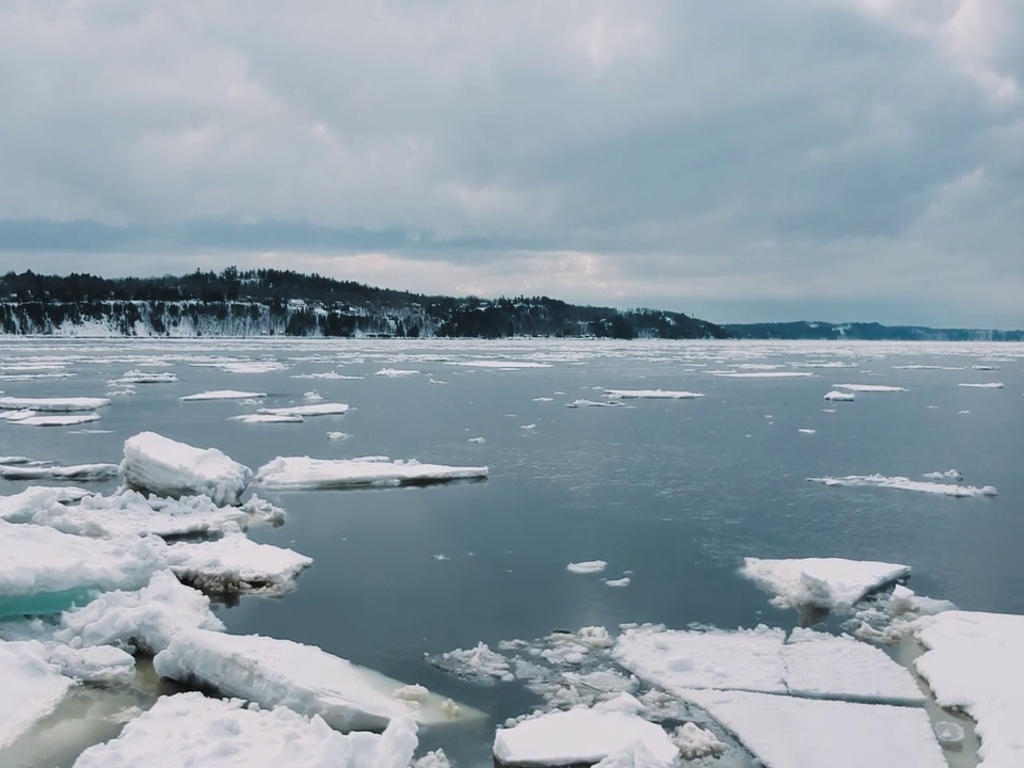

In [20]:
from PIL import Image

random_frame_index = np.random.choice(indices)
frame = video[np.where(indices == random_frame_index)[0][0]]
frame_image = Image.fromarray(frame)
frame_image = frame_image.resize((1024, 768))
frame_image

In [21]:
## 단순 프레임 RGB 평균 ##

# 계산된 평균 RGB 값
avg_rgb = np.mean(video, axis=(0, 1, 2))
avg_rgb = avg_rgb.astype(int)

# 유클리드 거리를 계산하는 함수
def rgb_distance(rgb1, rgb2):
    return np.sqrt(np.sum((np.array(rgb1) - np.array(rgb2)) ** 2))

# 가장 가까운 색상을 찾기
closest_colour = None
min_distance = float('inf')
for colour_name, note2 in chord_map.items():
    colour_rgb = colour_note_map[note2]
    distance = rgb_distance(avg_rgb, colour_rgb)
    if distance < min_distance:
        min_distance = distance
        closest_colour = colour_name

print(f"Average RGB of selected frames: {avg_rgb}")
print(f"Closest colour: {closest_colour}")

Average RGB of selected frames: [147 161 171]
Closest colour: dominant colour of this video is Rosé, Hex: #a9677c


In [23]:
## XCLIP에서 나온 각 색상별 확률을 고려한 평균 RGB ##

dominant_colour_boost = 6.0 #모델이 정한 dominant colour에 추가적인 가중치 부여

weighted_rgb = [0, 0, 0]
for i in range(len(classes)):
    note2 = chord_map[classes[i]]
    rgb = colour_note_map[note2]

    if classes[i] == classified_class:
        weight = probs[0][i].item() * dominant_colour_boost
    else:
        weight = probs[0][i].item()

    weighted_rgb[0] += rgb[0] * weight
    weighted_rgb[1] += rgb[1] * weight
    weighted_rgb[2] += rgb[2] * weight

total_weight = sum(probs[0]) + (dominant_colour_boost - 1) * probs[0][probs.argmax().item()]
predicted_rgb = [int(value / total_weight) for value in weighted_rgb]

def rgb_distance(rgb1, rgb2):
    return sum((a - b) ** 2 for a, b in zip(rgb1, rgb2)) ** 0.5

closest_colour = None
min_distance = float('inf')
for colour_name, note2 in chord_map.items():
    colour_rgb = colour_note_map[note2]
    distance = rgb_distance(predicted_rgb, colour_rgb)
    if distance < min_distance:
        min_distance = distance
        closest_colour = colour_name.replace('dominant colour of this video is ', '')

print(f"Predicted RGB: {predicted_rgb}, Closest colour: {closest_colour}")

Predicted RGB: [145, 70, 176], Closest colour: Steel colour with metallic sheen, Hex: #b7468b


In [152]:
from music21 import stream, chord, note, roman, scale, volume, environment

def generate_music(classified_note, duration: int = 60) -> None:
    scale_type = scale.MajorScale(classified_note + '4')
    notes = []
    for _ in range(duration):
        # 처음에 해당하는 스케일의 note가 나오도록 수정(Idea)
        degree = np.random.randint(1, 8)
        pitch = scale_type.pitchFromDegree(degree)
        new_note = note.Note(pitch.nameWithOctave)
        notes.append(new_note)

    music = stream.Stream(notes)
    music.write('midi', fp='/content/drive/MyDrive/Video2Music/midi_output/output.mid')

generate_music(classified_note)

In [153]:
def generate_music_with_first_scale(classified_note, duration: int = 60) -> None:
    scale_type = scale.MajorScale(classified_note + '4')
    notes = []

    # 첫 음을 해당 스케일의 1도(으뜸음)로 설정
    pitch = scale_type.pitchFromDegree(1)
    first_note = note.Note(pitch.nameWithOctave)
    notes.append(first_note)

    for _ in range(duration - 1):
        degree = np.random.randint(1, 8)
        pitch = scale_type.pitchFromDegree(degree)
        new_note = note.Note(pitch.nameWithOctave)
        notes.append(new_note)

    music = stream.Stream(notes)
    music.write('midi', fp='/content/drive/MyDrive/Video2Music/midi_output/output_with_first_scale.mid')

generate_music_with_first_scale(classified_note)

In [154]:
def generate_music_with_chords_progression(key, duration: int = 60) -> None:
    s = stream.Stream()
    chord_progressions = [
        ['I', 'V', 'vi', 'IV'],
        ['I', 'vi', 'IV', 'V'],
        ['I', 'IV', 'ii', 'V'],
        ['I', 'iii', 'vi', 'V'],
        ['I', 'V6', 'IV', 'V'],
        ['I', 'V6', 'vi', 'IV'],
        ['I', 'I6', 'IV', 'V'],
        ['I', 'I6', 'vi7', 'V']
    ]

    chord_progression = random.choice(chord_progressions)

    for _ in range(duration // len(chord_progression)):
        for numeral in chord_progression:
            rn = roman.RomanNumeral(numeral, key)
            c = chord.Chord(rn.pitches)
            c.duration.quarterLength = 1
            s.append(c)

    s.write('midi', fp='/content/drive/MyDrive/Video2Music/midi_output/output_with_chords_progression.mid')

generate_music_with_chords_progression(classified_note)

In [155]:

def generate_music_with_chords_progression_and_randomness(key, duration: int = 60) -> None:
    s = stream.Stream()
    chord_progressions = [
        ['I', 'V', 'vi', 'IV'],
        ['I', 'vi', 'IV', 'V'],
        ['I', 'IV', 'ii', 'V'],
        ['I', 'iii', 'vi', 'V'],
        ['I', 'V6', 'IV', 'V'],
        ['I', 'V6', 'vi', 'IV'],
        ['I', 'I6', 'IV', 'V'],
        ['I', 'I6', 'vi7', 'V']
    ]
    note_durations = [0.25, 0.5, 1]  # 16분 음표, 8분 음표, 4분 음표
    dynamics = ['pp', 'mf', 'ff']  # 다양한 다이내믹스
    chosen_chord_progression = random.choice(chord_progressions)

    # 총 음악 길이에 따라 반복 횟수 계산
    repeats = duration // (len(chosen_chord_progression) * 4)
    for _ in range(repeats):
        for numeral in chosen_chord_progression:
            rn = roman.RomanNumeral(numeral, key)
            pitches = random.sample(rn.pitches, k=random.randint(1, len(rn.pitches)))
            current_duration = random.choice(note_durations)
            current_dynamic = volume.Dynamic(random.choice(dynamics))
            for pitch in pitches:
                n = note.Note(pitch, quarterLength=current_duration)
                n.volume.velocityScalar = current_dynamic.dynamicMark
                s.append(n)

    s.write('midi', fp='/content/drive/MyDrive/Video2Music/midi_output/output_with_randomness.mid')

    generate_music_with_chords_progression_and_randomness(classified_note)

In [156]:
def play_midi_file(midi_file_path: str) -> None:
    mf = midi.MidiFile()
    mf.open(midi_file_path)
    mf.read()
    mf.close()
    midi_stream = midi.translate.midiFileToStream(mf)
    midi_stream.show('midi')

play_midi_file('/content/drive/MyDrive/Video2Music/midi_output/output.mid')

In [157]:
play_midi_file('/content/drive/MyDrive/Video2Music/midi_output/output_with_first_scale.mid')

In [158]:
play_midi_file('/content/drive/MyDrive/Video2Music/midi_output/output_with_chords_progression.mid')

In [159]:
play_midi_file('/content/drive/MyDrive/Video2Music/midi_output/output_with_randomness.mid')

In [87]:
!apt-get install fluidsynth -y -q

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0
  libxcb-keysyms1 libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-imag

In [160]:
!pip install midi2audio
from midi2audio import FluidSynth

def convert_midi_to_wav(midi_file: str, wav_file: str, sound_font: str) -> None:
    fs = FluidSynth(sound_font)
    fs.midi_to_audio(midi_file, wav_file)

midi_file = "/content/drive/MyDrive/Video2Music/midi_output/output_with_first_scale.mid"
wav_file = "/content/drive/MyDrive/Video2Music/wav_output/output_with_first_scale.wav"
sound_font = "/content/drive/MyDrive/Video2Music/GeneralUser GS 1.471/GeneralUser GS v1.471.sf2"

convert_midi_to_wav(midi_file, wav_file, sound_font)
print("Conversion complete!")

Conversion complete!


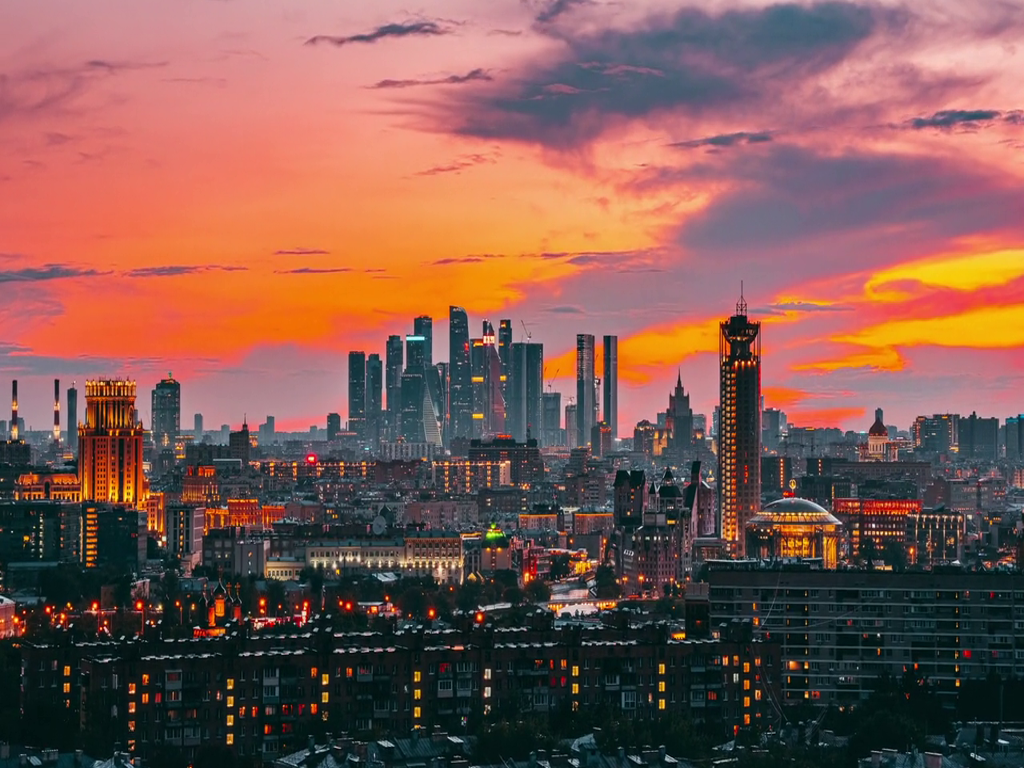

In [161]:
from PIL import Image

random_frame_index = np.random.choice(indices)
frame = video[np.where(indices == random_frame_index)[0][0]]
frame_image = Image.fromarray(frame)
frame_image = frame_image.resize((1024, 768))
frame_image

In [162]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2', trust_remote_code=True, torch_dtype=torch.float16)
model = model.to(device='cuda', dtype=torch.float16)

tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2', trust_remote_code=True)
model.eval()
print("model loaded.")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

model loaded.


In [163]:
question = 'Describe the overall feel of this photo as detailed as possible.'
msgs = [{'role': 'user', 'content': question}]

describe_text, context, _ = model.chat(
    image=frame_image,
    msgs=msgs,
    context=None,
    tokenizer=tokenizer,
    sampling=True,
    temperature=0.7
)
print(describe_text)

The image captures a breathtaking view of the city skyline at sunset. The sun, painted in hues of pink and orange as it sets behind clouds on one side while rising above them towards another corner, casts an ethereal glow over the bustling metropolis below. Skyscrapers illuminated with colorful lights stand tall against this vibrant backdrop, their silhouettes creating patterns that dance across the canvas created by nature's light show overhead.


In [164]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [165]:
import json

file_name = file_path.split('/')[-1].split('.')[0]
generation_dict = {
    'file_name': file_name,
    'classified_note': classified_note,
    'describe_text': describe_text
}

# JSON 파일로 저장
with open(f"/content/drive/MyDrive/Video2Music/{file_name}_generation_info.json", "w") as outfile:
    json.dump(generation_dict, outfile)